### DPCN Team Baby Sharks Project
- Amey Choudhary
- Aryan Gupta
- Keshav Gupta

In [212]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#### Implementing EMD 

In [213]:
# reading the dataset
file_path = "./Bangkok_Dengue.xlsx"
dataset = pd.read_excel(file_path)

print(dataset.head())
print(dataset.shape)

   Year Month  cases
0  2003   Jan     46
1  2003   Feb     29
2  2003   Mar     36
3  2003   Apr     47
4  2003   May    165
(180, 3)


[46]


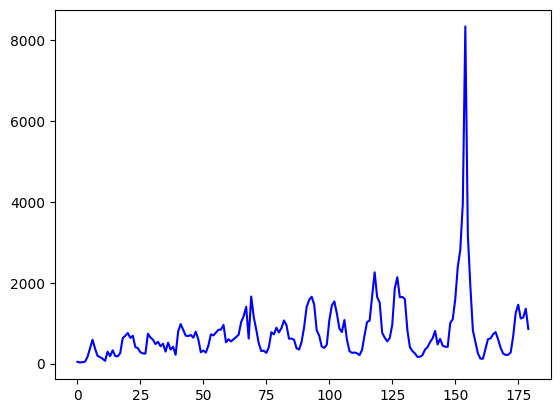

In [214]:
# convert to time series data
time_series_data = dataset.iloc[:, 2:].values
print(time_series_data[0])

plt.plot(time_series_data, color='blue')

In [215]:
cases_series = time_series_data[:, 0]


In [216]:
# library
from PyEMD import EMD

emd = EMD()
IMFs = emd.emd(cases_series)
n_imfs = IMFs.shape[0]


In [217]:
# aryan
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

def emd_a(signal, max_imfs=10):
    imfs = []
    # Ensure that residue is of float type
    residue = np.array(signal, dtype=float)
    n = len(signal)

    def is_imf(x):
        n_extrema = np.sum((np.diff(np.sign(np.diff(x))) != 0))
        n_zero_crossings = np.sum(np.diff(np.sign(x)) != 0)
        return np.abs(n_extrema - n_zero_crossings) <= 1
    
    for _ in range(max_imfs):
        h = residue.copy()
        sd = np.inf
        while sd > 0.1 or not is_imf(h):
            # Identify maxima and minima
            max_peaks = np.array([i for i in range(1, n - 1) if h[i] > h[i - 1] and h[i] > h[i + 1]])
            min_peaks = np.array([i for i in range(1, n - 1) if h[i] < h[i - 1] and h[i] < h[i + 1]])
            
            # Interpolate maxima and minima
            if len(max_peaks) < 2 or len(min_peaks) < 2:
                imfs.append(residue)
                return imfs
            max_env = CubicSpline(max_peaks, h[max_peaks], bc_type='natural')(np.arange(n))
            min_env = CubicSpline(min_peaks, h[min_peaks], bc_type='natural')(np.arange(n))
            
            # Mean of envelopes and new component (h)
            mean_env = (max_env + min_env) / 2
            prev_h = h.copy()
            h = h - mean_env
            
            # Calculate standard deviation as a stopping criterion
            # Avoid division by zero by adding a small constant (epsilon)
            epsilon = 1e-10
            sd = np.sum(((prev_h - h) ** 2) / (prev_h ** 2 + epsilon))
        
        imfs.append(h)
        residue -= h
    
    return imfs

# Replace 'dengue_data' with the actual variable containing your data
# Perform EMD on the signal
# cases_series = np.array(time_series_data, dtype=float)
IMFs_aryan= emd_a(cases_series, max_imfs=5)
n_imfs = len(IMFs_aryan)



In [218]:
# plotting the difference between the two methods
diff = []
for i in range(n_imfs):
    temp = []
    for j in range(len(IMFs[i])):
        dif = IMFs[i][j] - IMFs_aryan[i][j]
        dif = np.abs(dif)
        temp.append(dif)
    diff.append(temp)


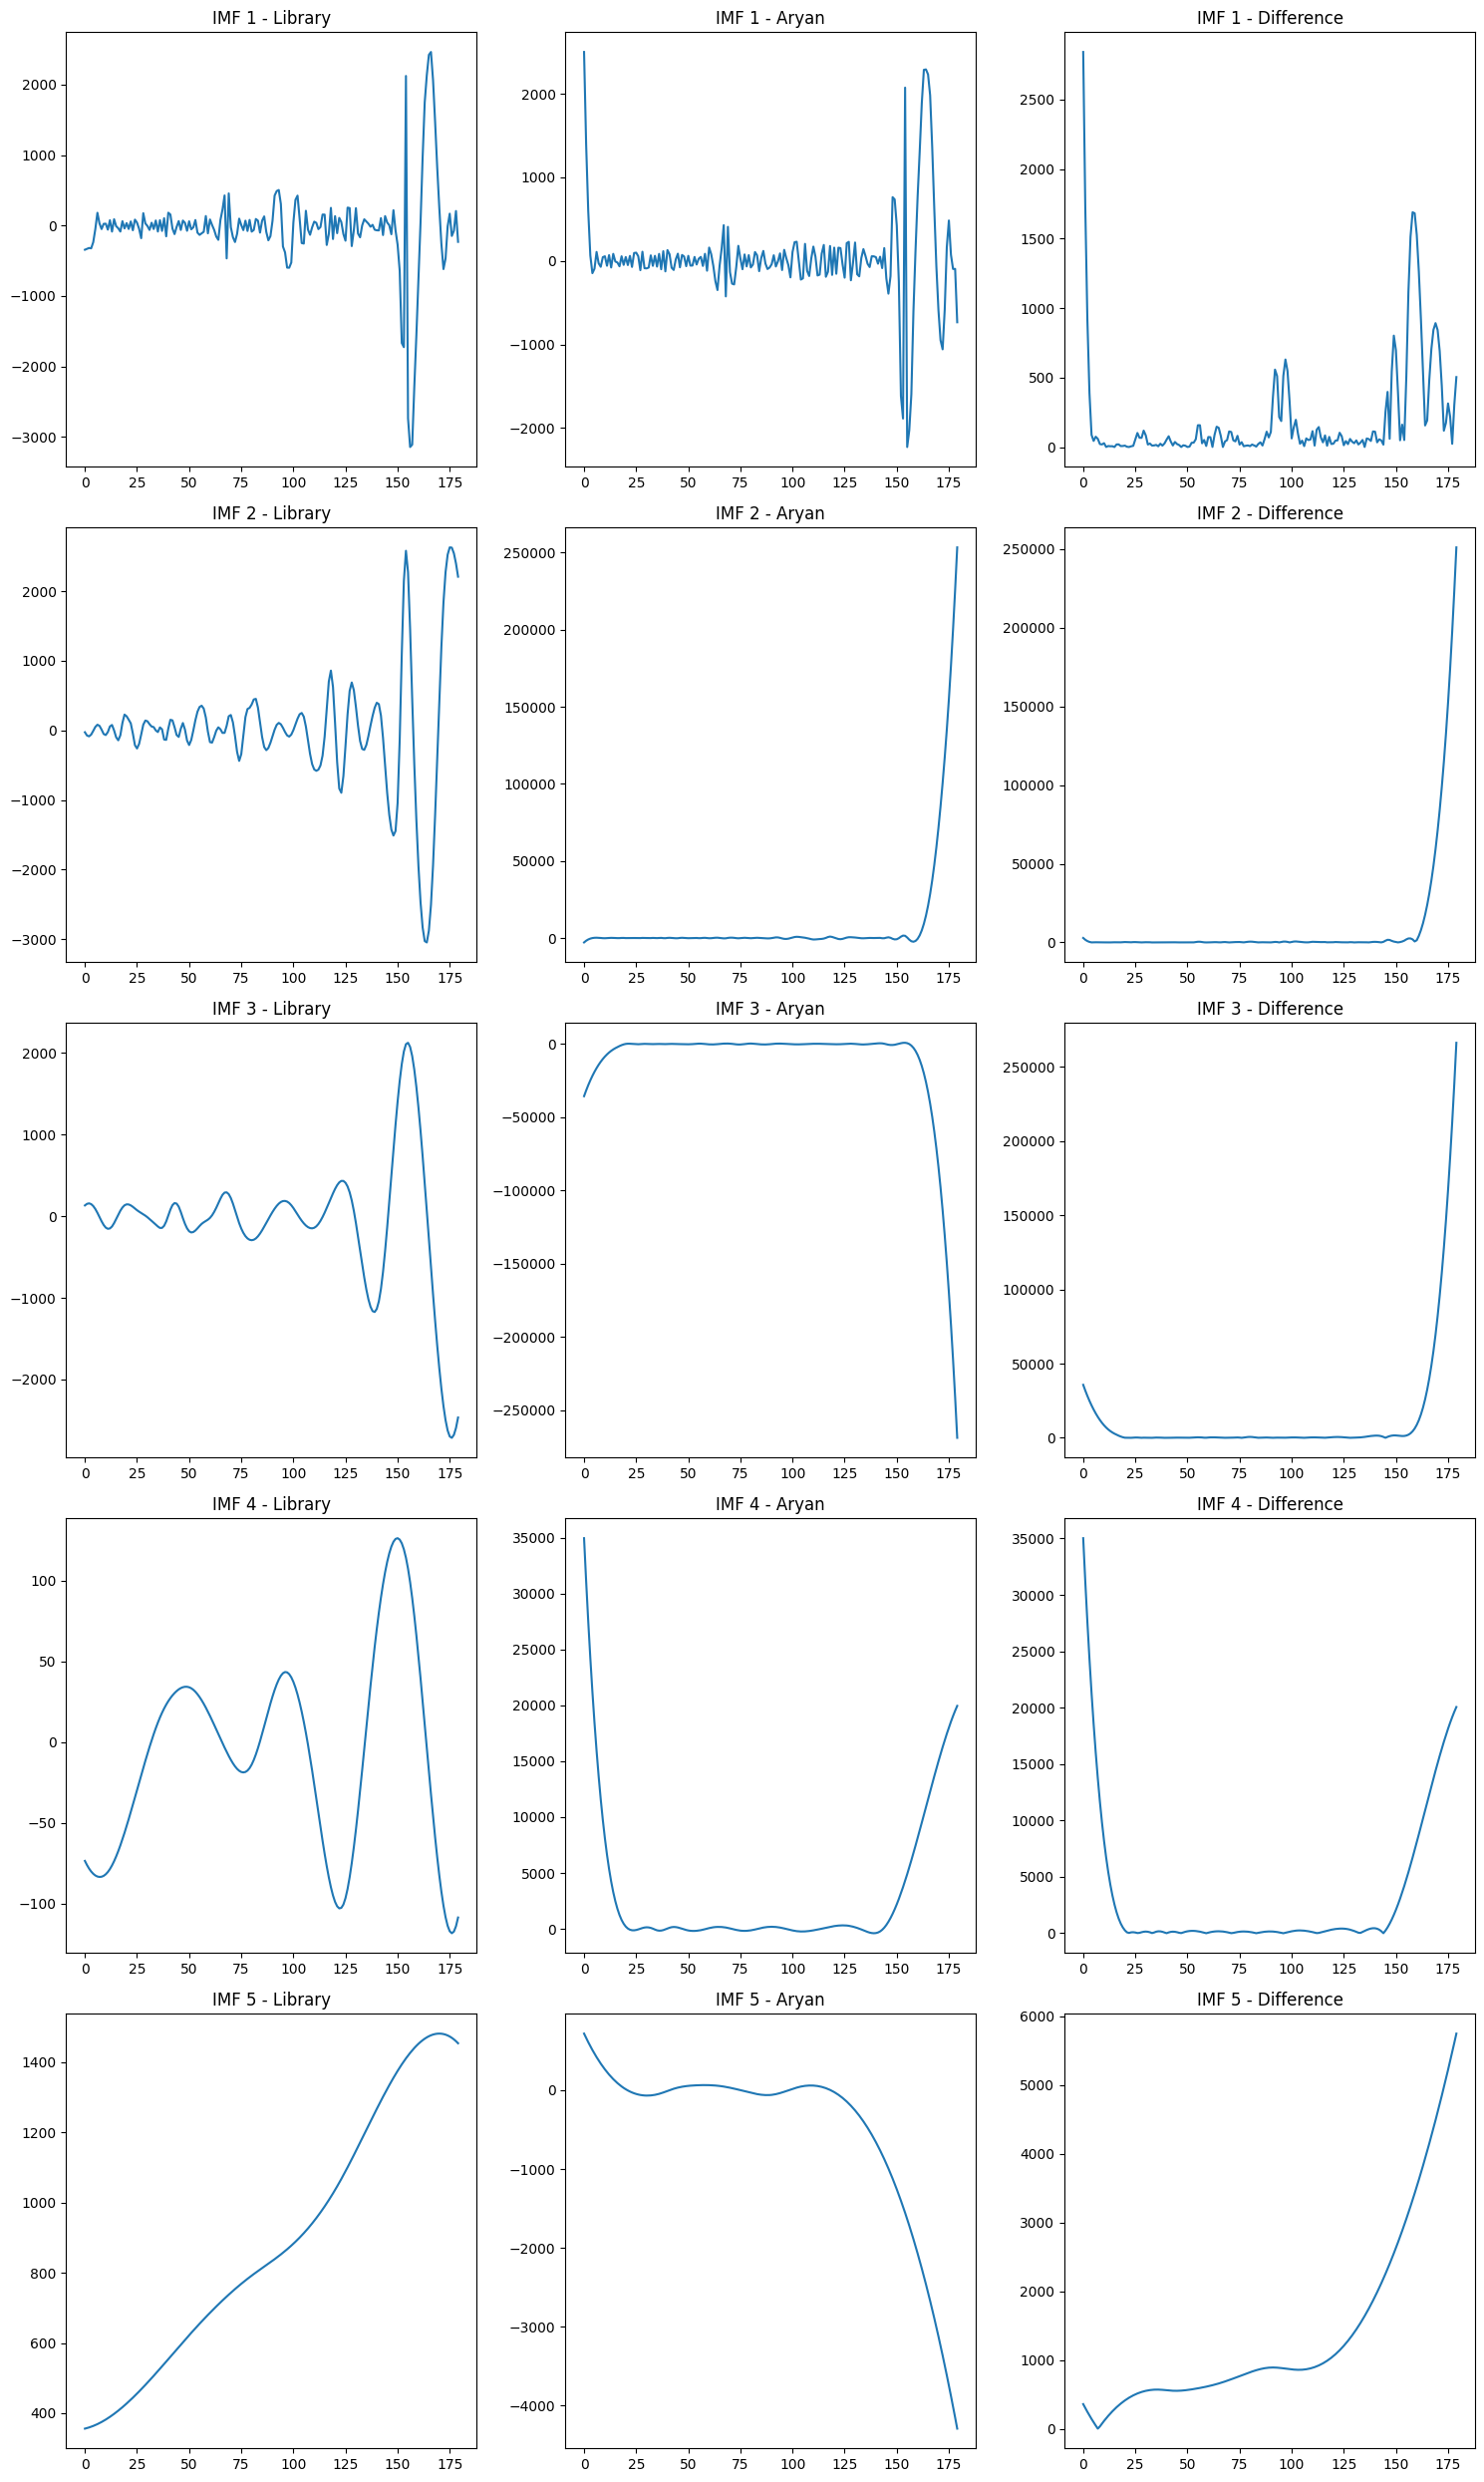

In [219]:

def plot_side_by_side(graphs_A, graphs_B, graphs_C):
    num_graphs = len(graphs_A)
    fig, axs = plt.subplots(num_graphs, 3, figsize=(15, num_graphs*5))  # Create subplots
    
    for i in range(num_graphs):
        axs[i, 0].plot(graphs_A[i])
        axs[i, 0].set_title(f'IMF {i+1} - Library')
        
        axs[i, 1].plot(graphs_B[i])
        axs[i, 1].set_title(f'IMF {i+1} - Aryan')
        
        axs[i, 2].plot(graphs_C[i])
        axs[i, 2].set_title(f'IMF {i+1} - Difference')
    plt.tight_layout()
    plt.show()

# Call the function to plot side by side
plot_side_by_side(IMFs, IMFs_aryan, diff)


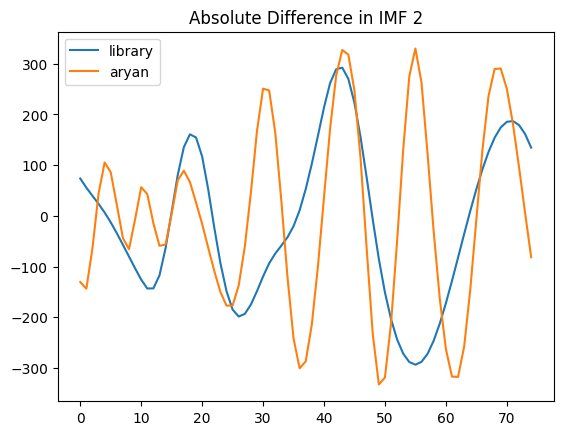

In [220]:
plt.plot(IMFs[2][25:100])
plt.plot(IMFs_aryan[2][25:100])
# plt.plot(diff[1][:100])
plt.legend([ 'library', 'aryan'])
plt.title(f'Absolute Difference in IMF {1+1}')

plt.show()


In [221]:
# not exactly the same but close in between. At the ends, really skewed. 
# Also doubt that we only send time series data of patients/cases and not rainfall.etc

In [222]:
# using pythonn's emd.

print(len(IMFs))
print(len(IMFs[0]))

5
180


In [223]:
case = [ 'short', 'medium', 'long']

p = [5, 6, 1]
p = np.array(p)

k = np.floor((p+1)/2).astype(int)

In [224]:
# autorgressive model ensemble

import torch
import torch.nn as nn

class neural_network(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(neural_network, self).__init__()
        self.linear1 = nn.Linear(input_size, hidden_size, )
        self.sigmoid = nn.Sigmoid()
        self.linear2 = nn.Linear(hidden_size, output_size)

        
    def forward(self, x):
        out = self.linear1(x)
        out = self.sigmoid(out)
        out = self.linear2(out)
        return out


# only some values will go in them
def train_ensemble(imfs, p, k, case_series):
    n_models = len(imfs)
    models = []

    # initialising model
    for i in range(n_models):
        model = neural_network(input_size=p, hidden_size=k, output_size=1)
        models.append(model)

    criterion = nn.MSELoss()

    # for loop
    for i in range(p, len(case_series)):
        input_imfs = []
        for j in range(n_models):
            input_imfs.append(imfs[j][i-p:i])
        y_true = case_series[i]
        y_true = torch.tensor(y_true).float()

        output_imfs = []

        # training
        parameters_list = []
        for j in range(n_models):
            model = models[j]
            # predicting the output
            output = model(torch.tensor(input_imfs[j]).float())
            output_imfs.append(output)
            parameters_list += list(model.parameters())

        
        optimizer = torch.optim.Adam(parameters_list, lr=0.001)                                           
        optimizer.zero_grad()

        # calculating the loss
        y_pred = sum(output_imfs)
        criterion = nn.MSELoss()
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()


    return models

train_test_split = 0.8
n = len(cases_series)
train_size = int(n * train_test_split)
test_size = n - train_size

forecast_Types = 'medium'

if forecast_Types == 'short':
    index = 0   
elif forecast_Types == 'medium':
    index = 1
else:
    index = 2

p_cute = p[index]
k_cute = k[index]

models = train_ensemble(IMFs[:][:train_size], p_cute, k_cute, cases_series[:train_size])




                                             





    
    



/home/ameychoudhary4/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [225]:
# testing the model
final_test_predictions = []
input_imfs = []

for j in range(len(IMFs)):
    input_imfs.append(IMFs[j][train_size-p_cute:train_size])


for i in range(train_size, n):

    output_preds = []

    for j in range(len(models)):
        model = models[j]
        output = model(torch.tensor(input_imfs[j][-p_cute:]).float())
        output = output.detach().numpy()
        output_preds.append(output)
    

    
    
    for j in range(len(input_imfs)):
        temp = input_imfs[j].tolist()
        temp.append(float(output_preds[j]))
        input_imfs[j] = np.array(temp)

    final_output = sum(output_preds)
    final_test_predictions.append(final_output)

   

/tmp/ipykernel_1537/1243172703.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  temp.append(float(output_preds[j]))


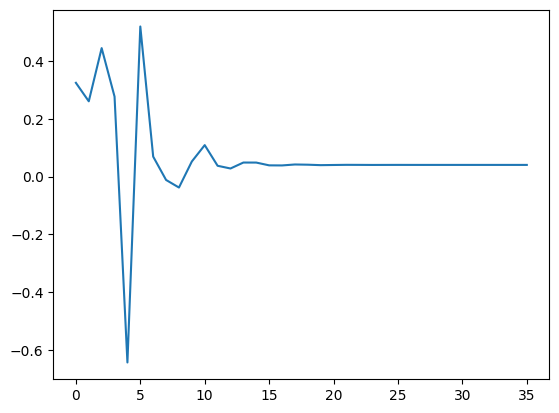

In [227]:
# comparing the with case series

plt.plot(cases_series[train_size:])
plt.plot(final_test_predictions)
plt.legend(['Actual', 'Predicted'])
plt.title(f'Actual vs Predicted Dengue Cases')
plt.show()
